In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4052E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4032E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4062E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4102E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4172E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4082E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4192E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4012E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4131E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4191E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4091E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4092E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4001E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4151E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4122E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4051E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4002E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4071E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4141E0.npz
/kaggle/input/eeg-fpz-cz/eeg_fpz_cz/SC4101E0.npz
/kaggle/input/eeg-fp

In [2]:
import os
import sys
import copy
import codecs
from glob import glob
from datetime import datetime
import random

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
DATA = "../input/sleep-state"
PP_DATA = "../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz"
WINDOW_SIZE = 100
bs = 64

In [6]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-wjzvhz6g
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-wjzvhz6g
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras_contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101060 sha256=25102d45254969c9269b0ba58aa3d82a1fe7e81b1714655328ec978b9563a3e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-bw_cosy_/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras_contrib


In [7]:
import tensorflow as tf
print(tf.__version__)

2024-03-18 15:29:29.852945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 15:29:29.853089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 15:29:30.131447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [8]:
!pip install mne

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_auc_score, roc_curve

import mne
from mne.io import read_raw_edf

In [ ]:
fnames = sorted(glob(os.path.join(PP_DATA, "*.npz")))

In [ ]:
len(fnames)

In [ ]:
fnames[0]

In [ ]:
total_fs = [f for f in fnames if f.split("/")[-1][:5]]

In [ ]:
len(total_fs), total_fs[0]

In [ ]:
total_data = {k: np.load(k) for k in total_fs}

In [ ]:
samples = total_data["../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz/SC4001E0.npz"]

In [ ]:
samples['x'].shape

In [ ]:
X = np.zeros((0, 3000, 1))
y = []
for fn in total_fs:
    samples = np.load(fn)
    X_data = samples["x"]
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples["y"])
y = np.array(y)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42
)

In [ ]:
X_train.shape, X_test.shape, X_val.shape

In [ ]:
def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X

def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, scale=True, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']

        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)

            if aug:
                X = aug_X(X)
                
            if scale:
                X = rescale_array(X)

            yield np.squeeze(X, axis=0), np.squeeze(Y, axis=0)

In [ ]:
def data_generator(X_samples, y_samples, bs=32, label=True):
    i = 0
#     X_samples = X_samples[:]
#     y_samples = y_samples[:]
    while True:
        X_temp = X_samples[i:i + bs]
        y_temp = y_samples[i:i + bs]
        
        X_temp = np.array([rescale_array(sample) for sample in X_temp])
        y_temp = np.array(y_temp)
        if label:
            yield X_temp, y_temp
        else:
            yield X_temp

        i += bs

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Attention
from tensorflow.keras.models import Model

def AttnSleep(input_shape, n_classes=5, summary=True):
    # Input layer
    input_layer = Input(shape=input_shape, name='input_layer')

    # Block 1
    conv1 = Conv1D(64, kernel_size=5, strides=1, padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    # Block 2
    conv2 = Conv1D(128, kernel_size=5, strides=1, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    # LSTM layer
    lstm = LSTM(128, return_sequences=True)(pool2)

    # Attention layer
    attention = Attention()([lstm, lstm])

    # Flatten and fully connected layers
    flatten = Flatten()(attention)
    fc1 = Dense(100, activation='relu')(flatten)
    fc1 = Dropout(0.5)(fc1)
    output_layer = Dense(n_classes, activation='softmax')(fc1)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name='AttnSleep')

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    if summary:
        model.summary()

    return model

# Assuming input shape (3000, 1), modify accordingly if it's different
input_shape = (3000, 1)
AttnSleep_model = AttnSleep(input_shape)


In [28]:
def evaluate_metrics(cm,classes):

    print ("Confusion matrix:")
    print (cm)

    cm = cm.astype(np.float32)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
    ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

    F1 = (2 * PPV * TPR) / (PPV + TPR)
    F1_macro = np.mean(F1)

    print ("Sample: {}".format(int(np.sum(cm))))
    n_classes = len(classes)
    for index_ in range(n_classes):
        print ("{}: {}".format(classes[index_], int(TP[index_] + FN[index_])))


    return ACC_macro,ACC, F1_macro, F1, TPR, TNR, PPV

In [29]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highpass, fs, order=4):
    nyq = 0.5 * fs
    #       low = lowcut / nyq
    high = highpass / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a
   
def butter_bandpass_filter(data, highpass, fs, order=4):
    b, a = butter_bandpass(0, highpass, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [30]:
sample = X_train[0]

In [31]:
max(sample), min(sample)

(array([44.09523773]), array([-42.00683594]))

In [32]:
res = butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4)

In [33]:
max(res), min(res)

(array([0.21273057]), array([-0.2026554]))

In [34]:
checkpoint = ModelCheckpoint("model_cps.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor="val_loss", mode="max", patience=20, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
#     early,
    redonplat,
    csv_logger,
]

In [35]:
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

In [37]:
hist = AttnSleep_model.fit(
    X_train, y_train_, batch_size=32, epochs=10, validation_data=(X_val, y_val_), callbacks=callbacks_list
)

Epoch 1/10
964/964 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.6878

W0000 00:00:1710388156.810078      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from -inf to 0.57009, saving model to model_cps.keras
964/964 [==============================] - 55s 57ms/step - loss: 0.8270 - accuracy: 0.6878 - val_loss: 0.5701 - val_accuracy: 0.7902 - lr: 1.0000e-04
Epoch 2/10
964/964 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.7631
Epoch 2: val_loss did not improve from 0.57009
964/964 [==============================] - 55s 57ms/step - loss: 0.6434 - accuracy: 0.7631 - val_loss: 0.5657 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 3/10
964/964 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.8102
Epoch 5: val_loss did not improve from 0.57009
964/964 [==============================] - 54s 56ms/step - loss: 0.5134 - accuracy: 0.8102 - val_loss: 0.5319 - val_accuracy: 0.8097 - lr: 1.0000e-04
Epoch 6/10
964/964 [==============================] - ETA: 0s - loss: 0.4962 - accuracy: 0.8179
Epoch 6: val_loss did not improve from 0.57009

Epoch 6: ReduceLROnPlateau reducing le

In [38]:
y_pred = AttnSleep_model.predict(X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)

W0000 00:00:1710388715.830649      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


67/67 [==============================] - 3s 30ms/step
>>> f1 score: 0.7616160497728963
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       854
           1       0.57      0.23      0.33       278
           2       0.89      0.89      0.89      1769
           3       0.89      0.90      0.90       563
           4       0.72      0.85      0.78       767

    accuracy                           0.85      4231
   macro avg       0.80      0.76      0.76      4231
weighted avg       0.84      0.85      0.84      4231



In [39]:
import pickle
with open('attnsleep.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

In [40]:
AttnSleep_model.save_weights("raw_model_2017.h5")

In [41]:
accuracy_score(y_test, y_pred)

0.8470810683053651

In [42]:
print(hist.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [43]:
overall_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

print("Overall Accuracy:", overall_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Loss:", loss)
print("Validation Loss:", val_loss)


Overall Accuracy: [0.6877634525299072, 0.7630828022956848, 0.7850658297538757, 0.8018611073493958, 0.810226321220398, 0.8179106116294861, 0.8369431495666504, 0.8417093753814697, 0.8477076888084412, 0.8465728759765625]
Validation Accuracy: [0.7901955246925354, 0.7761890888214111, 0.8185001611709595, 0.8147067427635193, 0.8097461462020874, 0.8281295299530029, 0.8386343717575073, 0.8395097851753235, 0.8395097851753235, 0.8374671936035156]
Loss: [0.8270216584205627, 0.6434158086776733, 0.5826924443244934, 0.5403271317481995, 0.5133692026138306, 0.4961797297000885, 0.4398178160190582, 0.4275491535663605, 0.4135341942310333, 0.4103505313396454]
Validation Loss: [0.5700929164886475, 0.5656841397285461, 0.4842498004436493, 0.47798535227775574, 0.5318977236747742, 0.44707441329956055, 0.42565789818763733, 0.42374470829963684, 0.4185643196105957, 0.4206709563732147]


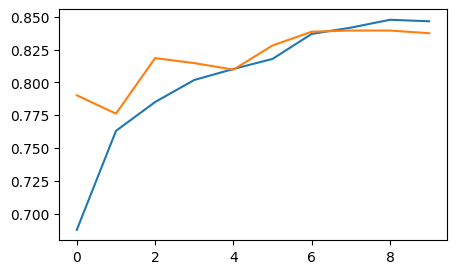

In [44]:
plt.figure(figsize=(5, 3))
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])

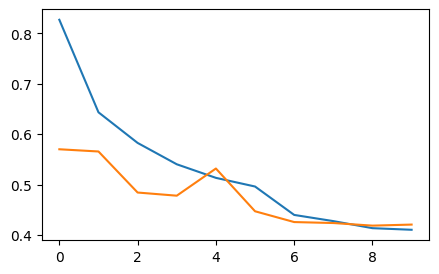

In [45]:
plt.figure(figsize=(5, 3))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

In [46]:
pp_X_train = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
pp_X_val = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
pp_X_test = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])

In [47]:
pp_X_train.shape

(30842, 3000, 1)

In [49]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=5)
y_val_onehot = to_categorical(y_val, num_classes=5)

# Then use these one-hot encoded labels to train the model
hist2 = AttnSleep_model.fit(
    pp_X_train, y_train_onehot, batch_size=32, epochs=10, validation_data=(pp_X_val, y_val_onehot), callbacks=callbacks_list
)


Epoch 1/10
964/964 [==============================] - ETA: 0s - loss: 0.4137 - accuracy: 0.8452
Epoch 1: val_loss did not improve from 0.57009
964/964 [==============================] - 55s 57ms/step - loss: 0.4137 - accuracy: 0.8452 - val_loss: 0.4204 - val_accuracy: 0.8416 - lr: 1.0000e-05
Epoch 2/10
964/964 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8493
Epoch 2: val_loss did not improve from 0.57009
964/964 [==============================] - 55s 57ms/step - loss: 0.4046 - accuracy: 0.8493 - val_loss: 0.4295 - val_accuracy: 0.8369 - lr: 1.0000e-05
Epoch 3/10
964/964 [==============================] - ETA: 0s - loss: 0.3997 - accuracy: 0.8505
Epoch 3: val_loss did not improve from 0.57009
964/964 [==============================] - 55s 57ms/step - loss: 0.3997 - accuracy: 0.8505 - val_loss: 0.4220 - val_accuracy: 0.8392 - lr: 1.0000e-05
Epoch 4/10
964/964 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8510
Epoch 4: val_loss did not

In [50]:
y_pred = AttnSleep_model.predict(pp_X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)

67/67 [==============================] - 2s 30ms/step
>>> f1 score: 0.7685600528570729
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       854
           1       0.58      0.26      0.35       278
           2       0.90      0.89      0.89      1769
           3       0.88      0.93      0.90       563
           4       0.73      0.85      0.78       767

    accuracy                           0.85      4231
   macro avg       0.80      0.77      0.77      4231
weighted avg       0.84      0.85      0.84      4231



In [51]:
accuracy_score(y_test, y_pred)

0.8506263294729378